# Intelligent Waste Assistant: Waste Classification Model Development

This Google Colab notebook serves as a development environment for building, training, and evaluating a waste classification model using the **Recyclable and Household Waste Classification** dataset from Kaggle.

## 1. Setup and Dependencies

Install necessary libraries and the Kaggle API.

In [1]:
# Install core libraries and Kaggle
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow
!pip install kaggle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from google.colab import files

## 2. Dataset Download (Kaggle)

Upload your `kaggle.json` file when prompted to authenticate and download the dataset.

In [5]:
import os
from google.colab import files

kaggle_json_filename = 'kaggle.json'
kaggle_json_path = os.path.join(os.getcwd(), kaggle_json_filename)

# Check if kaggle.json exists or needs renaming from kaggle (1).json
if not os.path.exists(kaggle_json_path):
    # Check for kaggle (1).json if kaggle.json doesn't exist
    if os.path.exists('kaggle (1).json'):
        os.rename('kaggle (1).json', kaggle_json_path)
        print(f"Renamed 'kaggle (1).json' to '{kaggle_json_filename}'")
    else:
        # If neither exists, prompt for upload
        print(f"Please upload your {kaggle_json_filename} file (download it from Kaggle Settings -> API -> Create New Token).")
        uploaded = files.upload()
        if uploaded:
            uploaded_file = list(uploaded.keys())[0]
            if uploaded_file != kaggle_json_filename:
                os.rename(uploaded_file, kaggle_json_filename)
                print(f"Renamed '{uploaded_file}' to '{kaggle_json_filename}'")
        else:
            print("No file was uploaded. Please upload kaggle.json to continue.")

# Proceed with Kaggle configuration if kaggle.json is now available
if os.path.exists(kaggle_json_path):
    print("Configuring Kaggle API...")
    !mkdir -p ~/.kaggle
    !cp {kaggle_json_path} ~/.kaggle/
    !chmod 600 ~/.kaggle/{kaggle_json_filename}

    # 3. Download the Dataset
    print("Downloading dataset...")
    !kaggle datasets download -d alistairking/recyclable-and-household-waste-classification

    # 4. Unzip
    print("Unzipping dataset...")
    # Check if the zip file exists before trying to unzip
    zip_file_name = "recyclable-and-household-waste-classification.zip"
    if os.path.exists(zip_file_name):
        !unzip -q {zip_file_name} -d waste_dataset
        print("Dataset prepared in 'waste_dataset' folder.")
    else:
        print(f"Error: {zip_file_name} not found. Download might have failed.")
else:
    print(f"Error: {kaggle_json_filename} not found. Cannot configure Kaggle API or download dataset.")

Renamed 'kaggle (1).json' to 'kaggle.json'
Configuring Kaggle API...
Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
 99% 914M/920M [00:12<00:00, 231MB/s]
100% 920M/920M [00:12<00:00, 80.1MB/s]
Unzipping dataset...
Dataset prepared in 'waste_dataset' folder.


## 3. Data Preprocessing

Loading images from the unzipped directory.

In [7]:
# Define the path.
# Based on this dataset structure, images are usually inside 'waste_dataset/images' or 'waste_dataset/recycling_waste_dataset'
# We will verify the folder structure first.
BASE_DIR = 'waste_dataset'
print("Contents of base dir:", os.listdir(BASE_DIR))

# Adjust this path based on the print output above if necessary.
# Assuming standard structure implies a subfolder named 'images' or direct class folders.
# For this specific dataset, it often contains an 'images' folder.
DATASET_PATH = os.path.join(BASE_DIR, 'images')

# If 'images' folder doesn't exist, checking if classes are in root
if not os.path.exists(DATASET_PATH):
    DATASET_PATH = BASE_DIR

# The previous execution showed 'Classes found: {'images': 0}'.
# This indicates that DATASET_PATH ('waste_dataset/images') contains another 'images' folder,
# and the actual class folders are within that nested 'images' directory.
# Let's correct DATASET_PATH to point to the correct parent of the class folders.
if os.path.exists(os.path.join(DATASET_PATH, 'images')):
    DATASET_PATH = os.path.join(DATASET_PATH, 'images')

print(f"Using dataset path: {DATASET_PATH}")

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # 20% validation split
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(f"Classes found: {train_generator.class_indices}")

Contents of base dir: ['README.txt', 'images']
Using dataset path: waste_dataset/images/images
Found 12000 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.
Classes found: {'aerosol_cans': 0, 'aluminum_food_cans': 1, 'aluminum_soda_cans': 2, 'cardboard_boxes': 3, 'cardboard_packaging': 4, 'clothing': 5, 'coffee_grounds': 6, 'disposable_plastic_cutlery': 7, 'eggshells': 8, 'food_waste': 9, 'glass_beverage_bottles': 10, 'glass_cosmetic_containers': 11, 'glass_food_jars': 12, 'magazines': 13, 'newspaper': 14, 'office_paper': 15, 'paper_cups': 16, 'plastic_cup_lids': 17, 'plastic_detergent_bottles': 18, 'plastic_food_containers': 19, 'plastic_shopping_bags': 20, 'plastic_soda_bottles': 21, 'plastic_straws': 22, 'plastic_trash_bags': 23, 'plastic_water_bottles': 24, 'shoes': 25, 'steel_food_cans': 26, 'styrofoam_cups': 27, 'styrofoam_food_containers': 28, 'tea_bags': 29}


## 4. Model Definition

Building a Convolutional Neural Network (CNN).

In [8]:
NUM_CLASSES = train_generator.num_classes

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,172,830 (42.62 MB)

 Trainable params: 11,172,830 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 195s 498ms/step - accuracy: 0.0454 - loss: 3.5707 - val_accuracy: 0.1636 - val_loss: 3.0084
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 186s 496ms/step - accuracy: 0.1510 - loss: 3.0517 - val_accuracy: 0.2648 - val_loss: 2.6227
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 186s 495ms/step - accuracy: 0.2335 - loss: 2.7365 - val_accuracy: 0.3706 - val_loss: 2.2796
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 185s 494ms/step - accuracy: 0.3000 - loss: 2.4865 - val_accuracy: 0.3982 - val_loss: 2.1003
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 186s 495ms/step - accuracy: 0.3505 - loss: 2.2865 - val_accuracy: 0.4489 - val_loss: 1.9546
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 187s 498ms/step - accuracy: 0.3844 - loss: 2.1576 - val_accuracy: 0.4499 - val_loss: 1.9134
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 189s 503ms/step - accuracy: 0.4228 - loss: 2.0315 - val_accuracy: 0.4892 - val_loss: 1.7566
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 491ms/step - accuracy: 0.4384 -

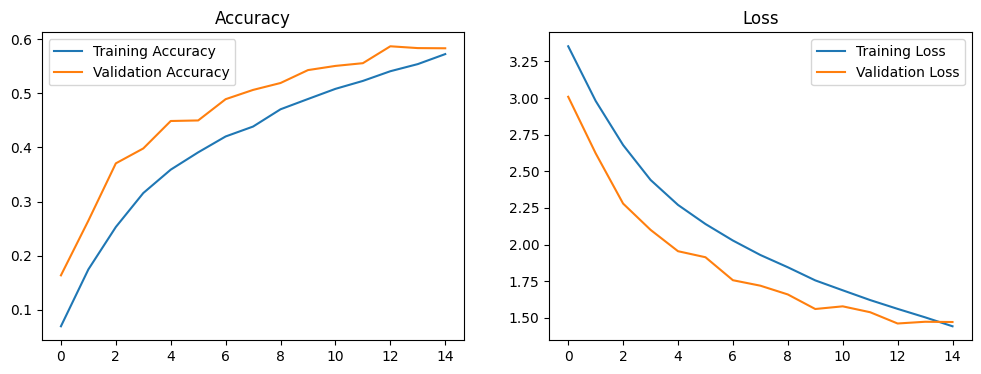

In [9]:
EPOCHS = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

## 6. Model Evaluation & Saving

In [10]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {accuracy:.4f}")

model.save("waste_classifier_model.h5")
print("Model saved as waste_classifier_model.h5")

94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 401ms/step - accuracy: 0.6007 - loss: 1.4352


Test Accuracy: 0.5907
Model saved as waste_classifier_model.h5
